In [ ]:
# basic package
import csv
import glob
import pandas as pd
import matplotlib as plt
from tqdm import tqdm
import numpy as np
import random
from operator import itemgetter
import matplotlib.pyplot as plt




# ml related 
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
political = pd.read_csv("political_selected.csv")
undernourish = pd.read_csv("undernourish_selected.csv")


In [ ]:
meaning_map = pd.read_csv("final_new_meaning_A.csv")

In [ ]:
meaning_map.head(3)

,Unnamed: 0,code,var_name
0,0,13575157,Pesticides (total) Agricultural Use
1,1,13095157,Insecticides Agricultural Use
2,2,13105157,Insecticides – Chlorinated Hydrocarbons Agricu...


# Function Definitions for Lasso

In [ ]:
# functions you will need 

def map_code_to_meaning(mapping, code_no):
    return (mapping.loc[mapping['code']==code_no]).iloc[0].var_name

# print the total percetnage of missing in each dataset
def total_percentage_missing(df):
    return(np.count_nonzero(df.isna()) / df.size)

# drop the top N rows with most NAs
def drop_top_N_rows_with_most_NAs(df, N=300):
    if N/len(df)> 0.2:
      warnings.warn("Based on your speficied N, you are dropping more then 20% of the data")

    print("shape before drop", df.shape)
    dict_nas = {}
    for i in range(len(df)):
        percentage = total_percentage_missing(df.iloc[i])
        dict_nas[i] = percentage
    res = dict(sorted(dict_nas.items(), key = itemgetter(1), reverse = True)[:N])
    # print("here")
    top_NAs_rows = list(res.keys())
    # print(top_NAs_rows)
    df.drop(top_NAs_rows, axis=0, inplace=True)
    print("shape after drop ", df.shape)
    print("Missing data percentage ", total_percentage_missing(df) )
    return df

# split into two dataset by year (default=2017)
# fist one include that year, second one is year after that
def split_by_year(df, split_at = 2017):
    res1 = df.loc[df['Year']<= split_at]
    res2 = df.loc[df['Year']> split_at]
    return res1, res2

def print_all_coeff(list_coef, feature_name):
    sort_index = reversed(np.argsort(list_coef))
    list_of_lists = []
    for i in sort_index:
#         print(feature_name[i])
        temp = int(feature_name[i])
        if list_coef[i] !=0.0:
            list_of_lists.append([round(list_coef[i],10), feature_name[i], map_code_to_meaning(meaning_map, temp)])
    return pd.DataFrame(list_of_lists, columns =['non_zero_coefficient', 'code', 'variable_name'])

  # pipeline on returning the coefficient of lasso regression
# also returns the score of the regressions
def lasso_pipeline_for_cross_validation(df, target_name = 'political', split_year = 2017, lasso_alpha = 0.12):

    if target_name not in df.columns:
        raise ValueError("The input dataframe doesn't have the column: political")
    
    if 'Continent' in df.columns:
      df = df.drop(columns =['Continent'])

    # default split at 2017
    political_pre_2017, political_post_2017 = split_by_year(df, split_at = split_year)
    
    # Note, the variable names here is only names, y_politcal can be any dataframe
    # doesn't have to be political 
    y_political = political_pre_2017.pop(target_name)
    X_political = political_pre_2017.drop(columns = ['Year', 'Area Code'])

    y_political_test = political_post_2017.pop(target_name)
    X_political_test = political_post_2017.drop(columns = ['Year', 'Area Code'])

    
    feature_names = X_political_test.columns

    # scale the X
    scaler = StandardScaler()
    political_scaler_X = scaler.fit(X_political)
    X_political_scaled = political_scaler_X.transform(X_political)
    X_political_test_scaled = political_scaler_X.transform(X_political_test)

    # scale the y
    y_political = y_political.values.reshape(-1,1)
    y_political_test = y_political_test.values.reshape(-1,1)
    political_scaler_y = scaler.fit(y_political)
    y_political_scaled = political_scaler_y.transform(y_political)
    y_political_test_scaled = political_scaler_y.transform(y_political_test)
    
    # Run LASSO
    reg = linear_model.Lasso(alpha=lasso_alpha).fit(X_political_scaled, y_political_scaled)
    
    
    y_train_pred = reg.predict(X_political_scaled) # predicting for training
    y_pred = reg.predict(X_political_test_scaled)  # predicting for testing
    
    
    r2_training = r2_score(y_political_scaled,y_train_pred)
    r2_resting = r2_score(y_political_test_scaled, y_pred)
    
   
    MAE_train = mean_absolute_error(y_political_scaled,y_train_pred)
    MAE_test = mean_absolute_error(y_political_test_scaled, y_pred)
    
    return MAE_train, r2_training, MAE_test, r2_resting

In [ ]:
political = drop_top_N_rows_with_most_NAs(df= political, N= 300)
undernourish = drop_top_N_rows_with_most_NAs(df= undernourish, N= 300)




# fill NAs
political = political.fillna(0)
undernourish = undernourish.fillna(0)


shape before drop (3705, 1002)
shape after drop  (3405, 1002)
Missing data percentage  0.003907896395168547
shape before drop (3933, 1002)
shape after drop  (3633, 1002)
Missing data percentage  0.02336230374373741


# Lasso Find crossvalidation


## Drawing for Political

In [ ]:
a = np.logspace(-1, -0.2, num=50)
a

In [ ]:

MAE_on_train = []  # MAE on train
MAE_on_test = [] # MAE on test
r2_on_train = []
r2_on_test = []

In [ ]:
for b in a: 
    MAE_train, r2_training, MAE_test, r2_resting = lasso_pipeline_for_cross_validation(political, target_name = 'political', lasso_alpha = b)
    MAE_on_train.append(MAE_train) # MAE on train
    MAE_on_test.append(MAE_test)
    r2_on_train.append(r2_training)
    r2_on_test.append(r2_resting)

In [ ]:
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(20,7))
plt.plot( a, MAE_on_train, label="Mean Absolute Error on Training (Year≤2017)")
plt.plot( a, MAE_on_test, label="Mean Absolute Error on Testing (Year>2017)")
plt.plot(a,r2_on_train, label='R squared on Training (Year≤2017)' )
plt.plot(a, r2_on_test, label = 'R squared on Testing (Year>2017)')
plt.xscale('log')
plt.xlabel("Choices of Alphas")
plt.ylabel("Value")
plt.legend(loc='center right')
plt.title("Political: In-sample and Out-of-sample Prediction Performance of LASSO with different Alphas")

## Drawing for Malnourishment

In [ ]:
a = np.logspace(-3.2, -0.1, num=50)
a

In [ ]:

MAE_on_train = []  # MAE on train
MAE_on_test = [] # MAE on test
r2_on_train = []
r2_on_test = []
for b in a: 
    MAE_train, r2_training, MAE_test, r2_resting = lasso_pipeline_for_cross_validation(undernourish, target_name = 'undernourish', lasso_alpha = b)
    MAE_on_train.append(MAE_train) # MAE on train
    MAE_on_test.append(MAE_test)
    r2_on_train.append(r2_training)
    r2_on_test.append(r2_resting)

In [ ]:
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(20,7))
plt.plot( a, MAE_on_train, label="Mean Absolute Error on Training (Year≤2017)")
plt.plot( a, MAE_on_test, label="Mean Absolute Error on Testing (Year>2017)")
plt.plot(a,r2_on_train, label='R squared on Training (Year≤2017)' )
plt.plot(a, r2_on_test, label = 'R squared on Testing (Year>2017)')
plt.xscale('log')
plt.xlabel("Choices of Alphas")
plt.ylabel("Value")
plt.legend(loc='lower center')
plt.title("Malnourish: In-sample and Out-of-sample Prediction Performance of LASSO with different Alphas")

# Random Forest

In [ ]:
def findElements(lst1, lst2):
    return [lst1[i] for i in lst2]

def reandom_forest(df, target_name = 'political', split_year = 2017, n_estimator= 80):

    if target_name not in df.columns:
        raise ValueError("The input dataframe doesn't have the column: political")
    
    if 'Continent' in df.columns:
      df = df.drop(columns =['Continent'])

    # default split at 2017
    political_pre_2017, political_post_2017 = split_by_year(df, split_at = split_year)
    
    # Note, the variable names here is only names, y_politcal can be any dataframe
    # doesn't have to be political 
    y_political = political_pre_2017.pop(target_name)
    X_political = political_pre_2017.drop(columns = ['Year', 'Area Code'])

    y_political_test = political_post_2017.pop(target_name)
    X_political_test = political_post_2017.drop(columns = ['Year', 'Area Code'])

    
    feature_names = X_political_test.columns

    # scale the X
    scaler = StandardScaler()
    political_scaler_X = scaler.fit(X_political)
    X_political_scaled = political_scaler_X.transform(X_political)
    X_political_test_scaled = political_scaler_X.transform(X_political_test)

    # scale the y
    y_political = y_political.values.reshape(-1,1)
    y_political_test = y_political_test.values.reshape(-1,1)
    political_scaler_y = scaler.fit(y_political)
    y_political_scaled = political_scaler_y.transform(y_political)
    y_political_test_scaled = political_scaler_y.transform(y_political_test)
    
    # print shapes
    print("Training Shape:", X_political_scaled.shape)
    print("Testing Shape", X_political_test_scaled.shape)
    
    # Run 
    random.seed(1234)
    rf = RandomForestRegressor(n_estimators=n_estimator)
    print(y_political_scaled.shape)
    rf.fit(X_political_scaled, y_political_scaled.ravel())
    
    std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
    
    y_train_pred = rf.predict(X_political_scaled)
    y_test_pred = rf.predict(X_political_test_scaled)
    print("Mean Absolute Error on training", mean_absolute_error(y_political_scaled, y_train_pred))
    print("Mean Absolute Error on testing",  mean_absolute_error(y_political_test_scaled, y_test_pred))
    return rf.feature_importances_, feature_names, std
    



# Random Forest on Entire Political Dataset 

In [ ]:
# n estimator = 80 
res, names , stds = reandom_forest(political, target_name = 'political')

Training Shape: (3041, 999)
Testing Shape (364, 999)
(3041, 1)
Mean Absolute Error on training 0.06174734667480838
Mean Absolute Error on testing 0.17015180120843582


Text(0.5, 1.0, 'Political Instability: Top 10 Mean Decrease in Impurity')

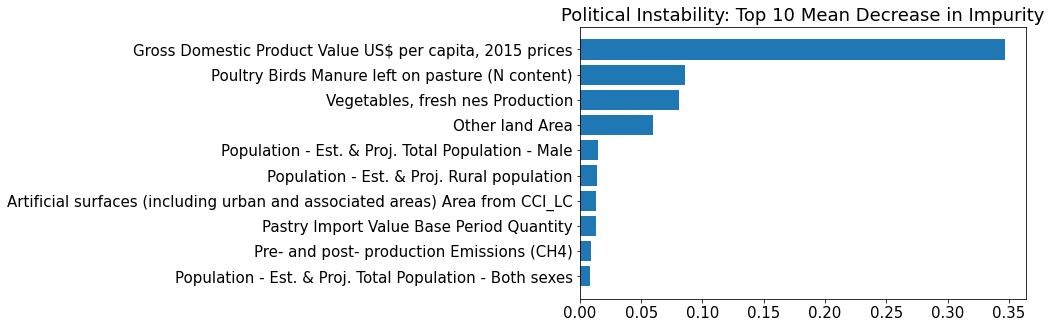

In [ ]:
N = 10
import_f = sorted(range(len(res)), key = lambda sub: res[sub])[-N:]

important_code = findElements(names,import_f )
important_stds = findElements(list(stds), import_f)

meanings_import = []

for each in important_code: 
    add = map_code_to_meaning(meaning_map,int(each))
    meanings_import.append(add)
    
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(8,5))
plt.barh(meanings_import, findElements(res,import_f ))
plt.title("Political Instability:" + " Top " +str(N) + " Mean Decrease in Impurity")

# Random Forest on Entire Undernourishment

In [ ]:
res_2,  names_2 , stds_2 = reandom_forest(undernourish, target_name = 'undernourish', n_estimator = 100)

Training Shape: (3055, 999)
Testing Shape (578, 999)
(3055, 1)
Mean Absolute Error on training 0.040287136709708536
Mean Absolute Error on testing 0.20992956457698583


Text(0.5, 1.0, 'Undernourishment: Top 10 Mean Decrease in Impurity')

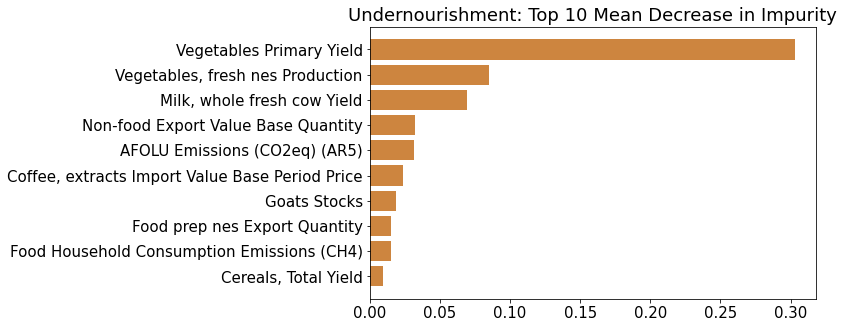

In [ ]:
N = 10
import_f = sorted(range(len(res_2)), key = lambda sub: res_2[sub])[-N:]

important_code = findElements(names_2,import_f )
important_stds = findElements(list(stds_2), import_f)

meanings_import = []

for each in important_code: 
    add = map_code_to_meaning(meaning_map,int(each))
    meanings_import.append(add)
    
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(8,5))
plt.barh(meanings_import, findElements(res_2,import_f ) , color='peru')
plt.title("Undernourishment: " + "Top " +str(N) + " Mean Decrease in Impurity")